# Predicting Dengue Fever Cases using weather data via Catboost Algorithm

### Introduction

This project aims to tackle the Dengue Fever Challenge posted on Driven Data.
Five steps are included in this markdown:
1. importing packages and reading data from source
2. conducting basic EDA (Exploration Data Analysis)
3. feature engineering
4. train a model and test result simply using training data
5. train the model again using all training data and do prediction for the 'submit' set

### Step 1: importing packages and reading data from source 

In [1]:
# import packages
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

Using TensorFlow backend.


In [2]:
# reading data
path = os.getcwd() + "/Data/"

data = {}
for file in os.listdir(path):
    data[re.sub(".csv", "", file)] = pd.read_csv(path + file)

training_X = data.pop("DengAI_Predicting_Disease_Spread_-_Training_Data_Features")
training_Y = data.pop("DengAI_Predicting_Disease_Spread_-_Training_Data_Labels")
submit_X = data.pop("DengAI_Predicting_Disease_Spread_-_Test_Data_Features")
submit_Y = data.pop("DengAI_Predicting_Disease_Spread_-_Submission_Format")

# joining data for train_test_split in the later stage
training = training_X.merge(training_Y, on=['city', 'year', 'weekofyear'], how='left')
submit = submit_X.merge(submit_Y, on=['city', 'year', 'weekofyear'], how='left')

### Step 2: conduct basic EDA (Exploratory Data Analysis)

In [3]:
# check the shape of training data
training.shape

(1456, 25)

In [4]:
# check the shape of submission data
submit.shape

(416, 25)

In [5]:
# take a look at the training data
training.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [6]:
# take a look at the submission data
submit.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,0
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,0
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,0
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,0


In [7]:
# check datatypes of each column
training.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [8]:
# check summary of the training data
training.describe(include='all')

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456,1456.000000,1456.000000,1456,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
unique,2,NaN,NaN,1049,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sj,NaN,NaN,2005-12-24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,936,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2001.031593,26.503434,NaN,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,NaN,5.408314,15.019437,NaN,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,NaN,1990.000000,1.000000,NaN,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,NaN,1997.000000,13.750000,NaN,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,NaN,2002.000000,26.500000,NaN,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,NaN,2005.000000,39.250000,NaN,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000


In [9]:
# check summary of the submission data
submit.describe(include='all')

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,416,416.000000,416.000000,416,373.000000,405.000000,415.000000,415.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,404.000000,404.000000,413.000000,407.000000,411.000000,416.0
unique,2,NaN,NaN,269,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,sj,NaN,NaN,2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,260,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2010.766827,26.439904,NaN,0.126050,0.126803,0.207702,0.201721,38.354324,298.818295,...,82.499810,38.354324,16.927088,5.124569,27.369587,7.810991,32.534625,22.368550,34.278589,0.0
std,NaN,1.434835,14.978257,NaN,0.164353,0.141420,0.079102,0.092028,35.171126,1.469501,...,7.378243,35.171126,1.557868,3.542870,1.232608,2.449718,1.920429,1.731437,34.655966,0.0
min,NaN,2008.000000,1.000000,NaN,-0.463400,-0.211800,0.006200,-0.014671,0.000000,294.554286,...,64.920000,0.000000,12.537143,1.485714,24.157143,4.042857,27.200000,14.200000,0.000000,0.0
25%,NaN,2010.000000,13.750000,NaN,-0.001500,0.015975,0.148670,0.134079,8.175000,297.751429,...,77.397143,8.175000,15.792857,2.446429,26.514286,5.928571,31.100000,21.200000,9.100000,0.0
50%,NaN,2011.000000,26.000000,NaN,0.110100,0.088700,0.204171,0.186471,31.455000,298.547143,...,80.330000,31.455000,17.337143,2.914286,27.483333,6.642857,32.800000,22.200000,23.600000,0.0
75%,NaN,2012.000000,39.000000,NaN,0.263329,0.242400,0.254871,0.253243,57.772500,300.240357,...,88.328929,57.772500,18.174643,8.171429,28.319048,9.812500,33.900000,23.300000,47.750000,0.0


In [10]:
# Check if there is any NA in training data
training.isnull().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [11]:
# Check if there is any NA in submission data
submit.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

<Figure size 432x288 with 0 Axes>

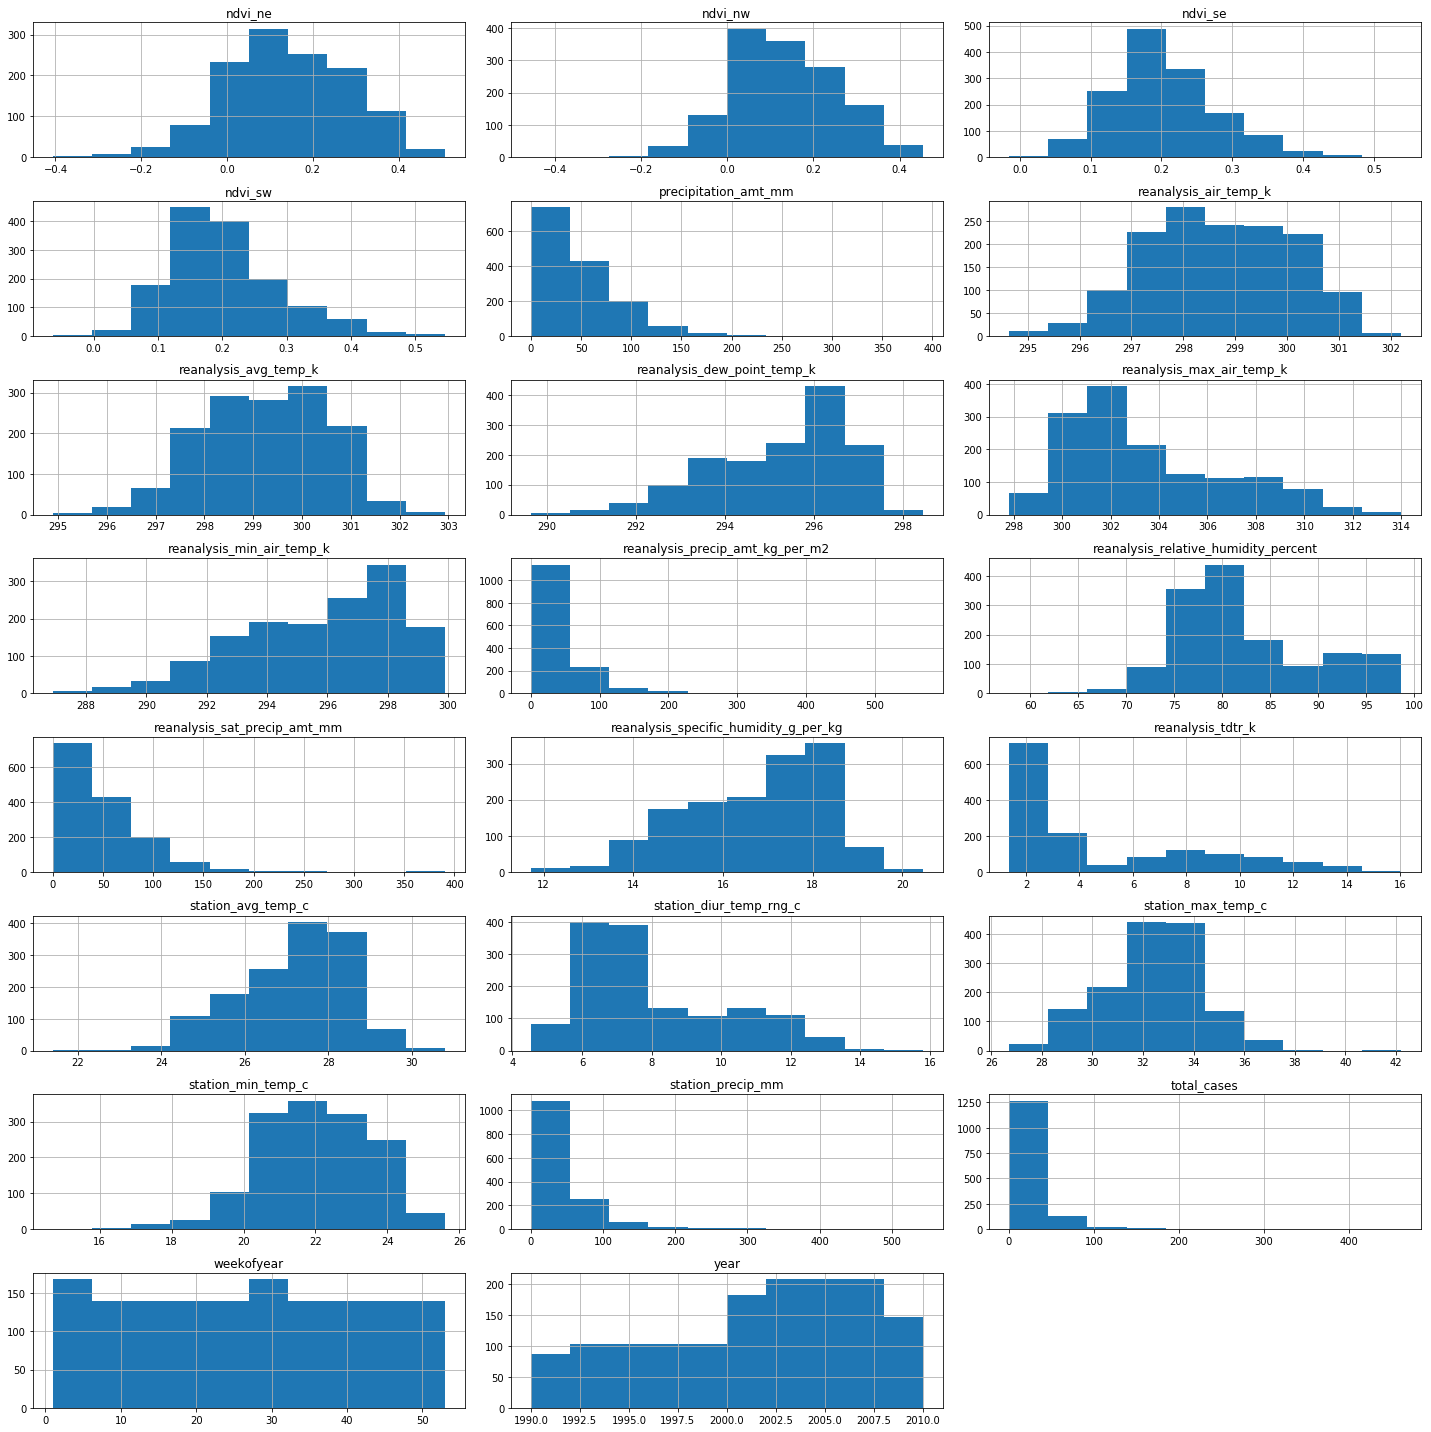

In [12]:
# Observe histogram of each numeric feature
plt.figure()
training.hist(figsize=(20,20), layout=(8,3))
plt.tight_layout()
plt.show()

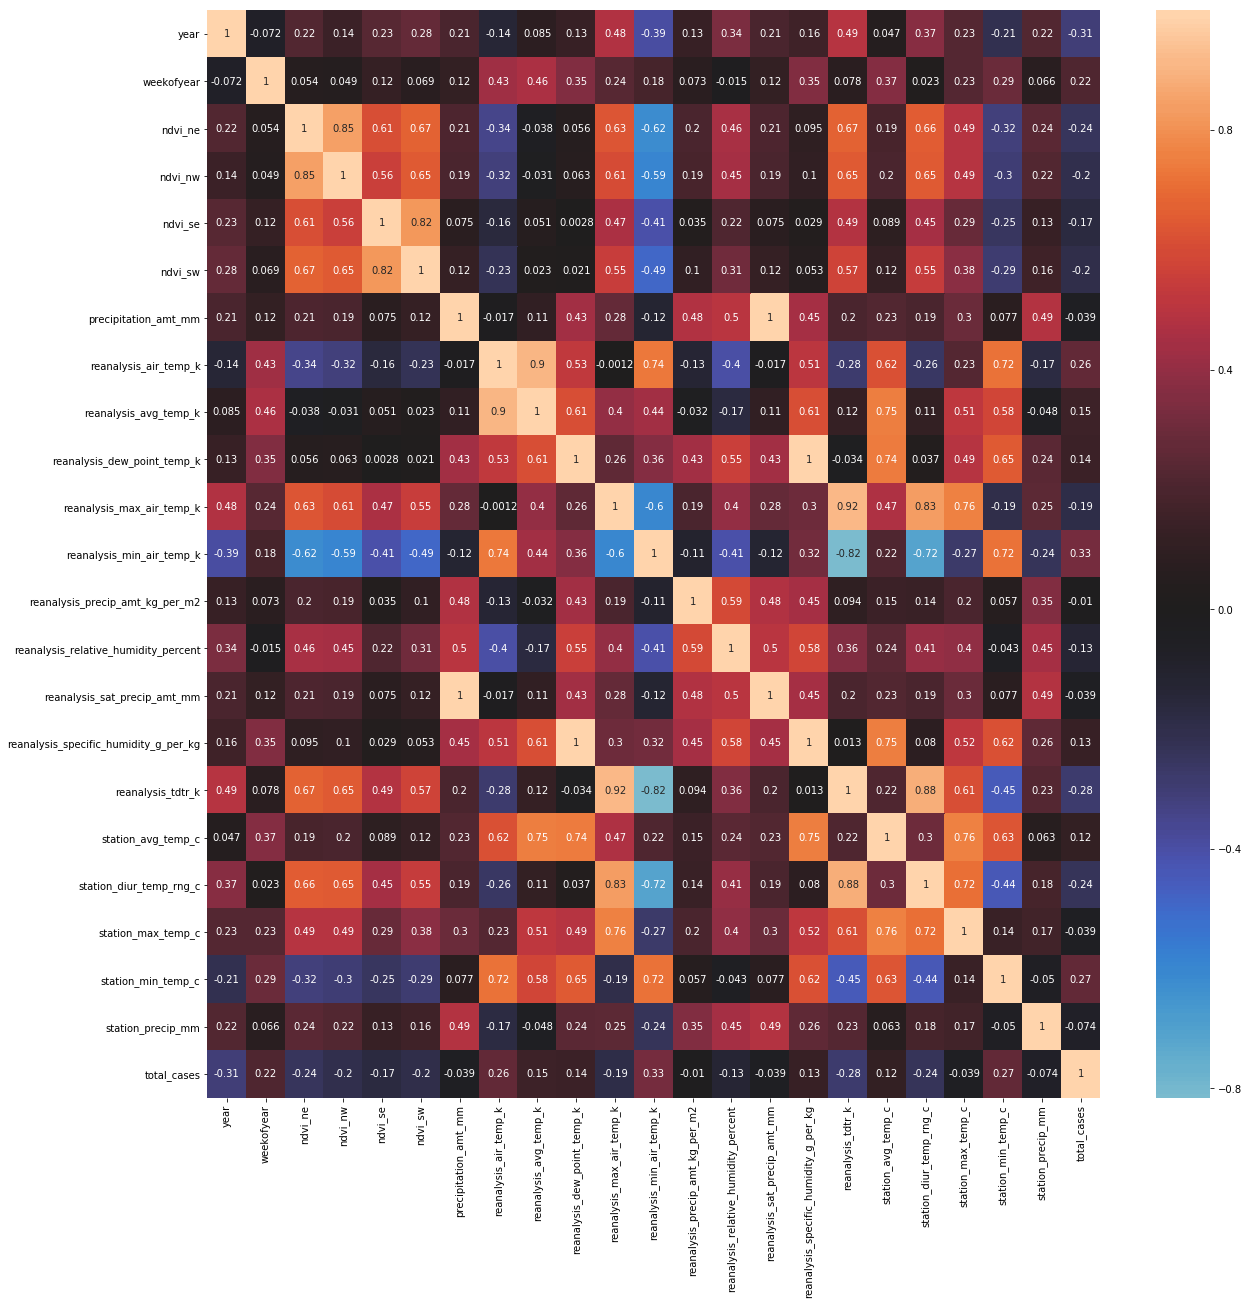

In [13]:
# Explore correlation between variables
plt.figure(figsize=(20,20))
sns.heatmap(training.corr(), xticklabels=training.corr().columns, yticklabels=training.corr().columns, center=0, annot=True)
plt.show()

### Step 3: feature engineering

Based on the exploratory data analysis, it seems that the following steps could/should be done:
1. generating datetime features
2. filling NAs
3. removing highly correlated features
4. one-hot encoding for categorical features

For step 2, since the NA values for each column are weather related data, it makes sense to fillna in groups of city and month.
And as the NA values only accounts for less than 10% of the total data for each column, a naive method, median would be used.

In [14]:
# generating date_time features
training['week_start_date'] = pd.to_datetime(training['week_start_date'], format='%Y-%m-%d')
training['quarter'] = training.week_start_date.dt.quarter
training['month'] = training.week_start_date.dt.month
training['day'] = training.week_start_date.dt.day

submit['week_start_date'] = pd.to_datetime(submit['week_start_date'], format='%Y-%m-%d')
submit['quarter'] = submit.week_start_date.dt.quarter
submit['month'] = submit.week_start_date.dt.month
submit['day'] = submit.week_start_date.dt.day

In [15]:
# fillna via naive method, median, grouped by city and month
training = training.groupby(['city', 'month'], as_index=False).apply(lambda x: x.fillna(x.median())).reset_index(drop=True)
submit = submit.groupby(['city', 'month'], as_index=False).apply(lambda x: x.fillna(x.median())).reset_index(drop=True)

In [16]:
# Remove some highly correlated non-datetime related features (absolute correlation > 0.9)
features_to_remove = ['reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_avg_temp_k', 'reanalysis_tdtr_k']
training.drop(features_to_remove, axis=1, inplace=True)
submit.drop(features_to_remove, axis=1, inplace=True)

In [17]:
# one-hot encoding for categorical data: city
training = pd.concat([pd.get_dummies(training.city).astype(int), training], axis=1)
submit = pd.concat([pd.get_dummies(submit.city).astype(int), submit], axis=1)

### Step 4: train a model and test result simply using training data

This step helps us understand the accuracy of our model before using it to predict the 'submit' dataset

In [18]:
# drop week_start_date before training
training.drop(['week_start_date'], axis=1, inplace=True)
submit.drop(['week_start_date'], axis=1, inplace=True)

In [19]:
# train test split for train, test and cv and then drop categorical variable: city
X_train, X_test, y_train, y_test = train_test_split(training.drop(['total_cases'], axis=1), training.total_cases, test_size=0.2, stratify=training.city, random_state=123)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, stratify=X_train.city, random_state=123)

X_train.drop(['city'], axis=1, inplace=True)
X_cv.drop('city', axis=1, inplace=True)
X_test.drop('city', axis=1, inplace=True)

In [20]:
# Build the NN model
model = Sequential()
model.add(Dense(46, input_dim=23, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(92, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(46, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(23, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

In [21]:
# Train the NN model
training_info = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), batch_size=25, epochs=600, shuffle=True, verbose=False)

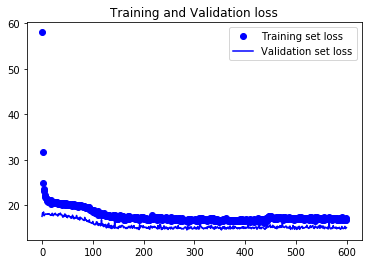

In [22]:
# Inspect loss over epochs
loss = training_info.history['loss']
val_loss = training_info.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training set loss')
plt.plot(epochs, val_loss, 'b', label='Validation set loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [23]:
# check result
y_pred = model.predict(X_test)
print('Mean Absolute Error:', MAE(y_test, y_pred))

Mean Absolute Error: 19.89015585918949


### Step 5: train the model again using all training data and do prediction for the 'submit' set

In [24]:
# train test split for train, and cv
X_train, X_cv, y_train, y_cv = train_test_split(training.drop(['total_cases'], axis=1), training.total_cases, test_size=0.3, stratify=training.city, random_state=123)
X_train.drop('city', axis=1, inplace=True)
X_cv.drop('city', axis=1, inplace=True)

In [25]:
# build model
submission_model = model.fit(X_train, y_train, validation_data=(X_cv, y_cv), batch_size=25, epochs=600, shuffle=True, verbose=False)

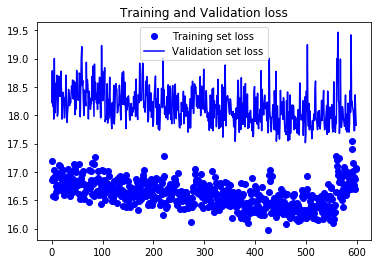

In [26]:
# Inspect loss over epochs
loss = submission_model.history['loss']
val_loss = submission_model.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo', label='Training set loss')
plt.plot(epochs, val_loss, 'b', label='Validation set loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [27]:
# do prediction on the 'submit' data and save as csv for final submission
submit_Y.total_cases = model.predict(submit.drop(['total_cases', 'city'], axis=1)).astype(int)
submit_Y.to_csv('submission.csv', index=False)